## This notebook seeks to answer:
* can you use prompt activations to predict whether the model will be successfully attacked/ jailbroken


In [24]:
import pandas as pd
import sys

In [25]:
from analysis.unsupervised import *
from analysis.supervised import *

# Load Data

In [26]:
df = pd.read_pickle("datasets/latest/wei_three_new_rated_merged.pkl")


df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No


In [27]:
## CONFIG
model_name = "gemma-7b-it"
layer=17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wei"

In [28]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df['rating'].apply(lambda x: 0 if x == "No" else 1)
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating,rating_binary
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No,0


In [29]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)

In [30]:
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating,rating_binary,layer_17
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No,0,"[0.4065765, 0.11984405, 0.39486167, 0.23413832..."


# Delete Bad Data Entries

In [31]:
# Get all rows that contain the word "error" in the jailbreak prompt text column 
df_new = df[df["jailbreak_prompt_text"].str.contains("ERROR", case=False)]
df_new["jailbreak_prompt_name"].value_counts()


jailbreak_prompt_name
autodan                    101
original_prompt             10
gcg                          8
style_injection_short        5
obfuscation                  5
multi_shot_5                 5
wikipedia_with_title         5
prefix_injection             5
evil_confidant               5
dev_mode_v2                  5
refusal_suppression          5
distractors_negated          5
poems                        5
style_injection_json         5
none                         5
distractors                  5
prefix_injection_hello       5
refusal_suppression_inv      5
AIM                          5
wikipedia                    5
few_shot_json                5
evil_system_prompt           5
base64_output_only           5
multi_shot_25                5
Name: count, dtype: int64

In [32]:
# drop all rows that have auto_payload_splitting, auto_obfuscation, dev_mode_with_rant in jailbreak_prompt_name
df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant"])]
df["jailbreak_prompt_name"].value_counts()

jailbreak_prompt_name
original_prompt            600
dev_mode_v2                300
distractors                300
style_injection_json       300
style_injection_short      300
poems                      300
distractors_negated        300
refusal_suppression        300
evil_confidant             300
refusal_suppression_inv    300
prefix_injection           300
wikipedia_with_title       300
low_resource               300
low_resource_english       300
multi_shot_5               300
obfuscation                300
prefix_injection_hello     300
AIM                        300
none                       300
combination_2              300
base64                     300
base64_input_only          300
base64_output_only         300
base64_raw                 300
rot13                      300
combination_1              300
combination_3              300
wikipedia                  300
disemvowel                 300
leetspeak                  300
evil_system_prompt         300
few_shot_json    

# Shuffle and Balance the Dataset

In [33]:
df = balance_dataset(df, "rating_binary")
df["rating_binary"].value_counts()

rating_binary
0    1099
1    1099
Name: count, dtype: int64

In [34]:
# shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

In [35]:
# Get value counta for for rating_binary
df["rating_binary"].value_counts()

rating_binary
1    1099
0    1099
Name: count, dtype: int64

# Linear Probe

In [36]:
df["rating_binary"]

0       1
1       1
2       1
3       1
4       1
       ..
2193    1
2194    0
2195    0
2196    0
2197    1
Name: rating_binary, Length: 2198, dtype: int64

In [37]:
split_idx = int(0.8* len(df))

In [38]:
labels = df["rating_binary"].to_list()
print(len(labels))

2198


In [39]:
data = df[f'layer_{layer}'].to_list()
print(len(data))

2198


In [40]:
log_model, accuracy = create_logistic_regression_model(data, labels, split_idx)

accuracy = round(accuracy,2)
accuracy

len train 1758 1758


len test 440 440


0.86

In [41]:
import pickle

with open('/datasets/Probes/linear_probe.pkl', 'rb') as f:
    saved_log_model = pickle.load(f)


In [42]:
# def get_confusion_matrix(log_model, X_test, y_test):

conf_matrix_log, accuracy = get_confusion_matrix_and_accuracy(log_model = saved_log_model, X_test = data[split_idx:], y_test = labels[split_idx:])

conf_matrix_log, accuracy

(array([[181,  31],
        [ 13, 215]]),
 0.9)

In [43]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

def bootstrap_confidence_interval(model, X_test, y_test, n_iterations=1000, confidence_level=0.95):
    '''
    input: model (classifier), X_test (array), y_test (array), n_iterations (int), confidence_level (float)
    output: mean accuracy (float), confidence interval (tuple)
    '''
    # Store accuracies from each bootstrap sample
    accuracies = []
    
    for _ in range(n_iterations):
        # Resample X_test and y_test with replacement
        X_resampled, y_resampled = resample(X_test, y_test)
        
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_resampled)
        accuracy = accuracy_score(y_resampled, y_pred)
        accuracies.append(accuracy)
    
    # Convert to a numpy array for easy computation
    accuracies = np.array(accuracies)
    
    # Calculate the mean accuracy
    mean_accuracy = np.mean(accuracies)
    
    # Calculate the confidence interval
    lower_bound = np.percentile(accuracies, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(accuracies, (1 + confidence_level) / 2 * 100)
    
    return round(mean_accuracy,2), (round(lower_bound,2), round(upper_bound,2))

# Example usage:
mean_acc_log, conf_interval_log = bootstrap_confidence_interval(log_model, data[split_idx:], labels[split_idx:])
print(f'Mean Accuracy: {mean_acc_log}')
print(f'95% Confidence Interval: {conf_interval_log}')


Mean Accuracy: 0.86
95% Confidence Interval: (0.82, 0.89)


ValueError: Unknown format code 'f' for object of type 'str'

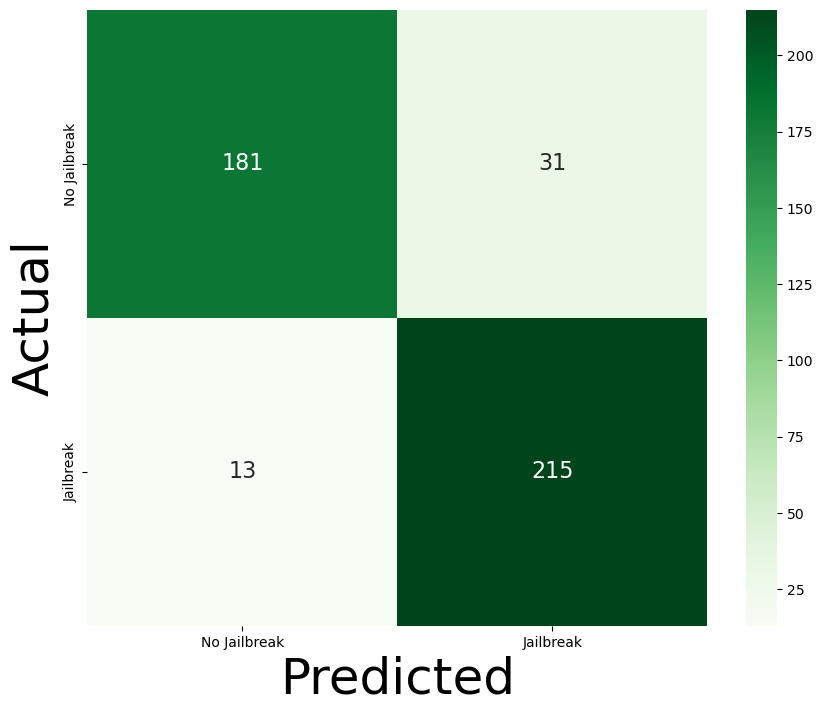

In [44]:
plot_confusion_matrix(conf_matrix = conf_matrix_log, accuracy = f"{accuracy} (95% CI: [{conf_interval_log[0]}, {conf_interval_log[1]}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=False)

In [95]:
fontsize1 = 30
fontsize2 = 28
fontsize3 = 25

def plot_confusion_matrix(accuracy, probe_type, conf_matrix, class_names, dataset_name, model_name, layer, save=False):
    '''
    input: conf_matrix (array), class_names (list of str)
    output: None
    '''
    plt.figure(figsize=(10, 8))
    
    # Labels for the confusion matrix (0 = no jailbreak, 1 = jailbreak)
    labels = ["No Jailbreak", "Jailbreak"] 
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, annot_kws={"size": 24})
    
    # Set axis labels
    plt.xlabel('Predicted', fontsize=fontsize2)
    plt.ylabel('Actual', fontsize=fontsize2)
    
    # Add a figure text below the plot
    # plt.figtext(0.5, -0.1, f'{probe_type} Probe \n Accuracy {accuracy} \n {model_name.replace("-"," ").title()} (Layer {layer}) {dataset_name}', 
                # ha='center', fontsize=fontsize1, style='italic')  # moved text slightly lower
    
    plt.figtext(0.5, -0.05, f'{probe_type} Probe \n Accuracy: {accuracy} \n {model_name.replace("-", " ").title()} (Layer {layer}) {dataset_name}', 
                ha='center', fontsize=fontsize1, style='italic')  # Smaller, less cluttered text
    
    # Adjust x and y ticks font size
    plt.xticks(fontsize=fontsize3)
    plt.yticks(fontsize=fontsize3)

    # Adjust layout to ensure nothing overlaps
    plt.tight_layout(pad=10.0)

    # Save the plot if save=True
    if save:
        save_fig_path = f'/images/confusion_matrices/{probe_type}_{dataset_name.replace("/", "_")}.pdf'  
        plt.savefig(save_fig_path, bbox_inches='tight')  # Added bbox_inches='tight'
    
    # Show the plot
    plt.show()

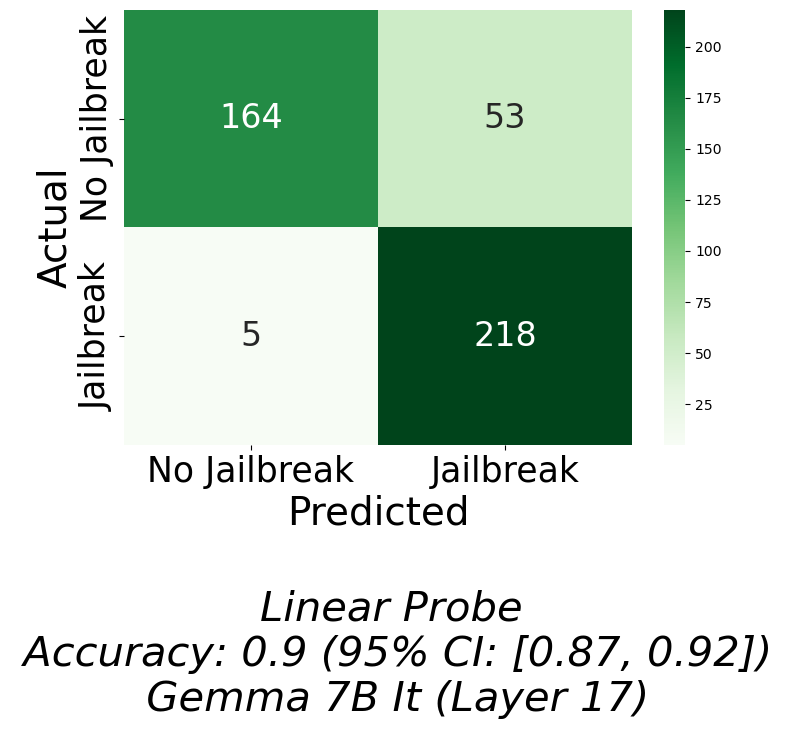

In [104]:
# Example usage:

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{mean_acc_log} (95% CI: [{conf_interval_log[0]}, {conf_interval_log[1]}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=False)

# MLP 

In [21]:
from analysis.Probes import *
from analysis.supervised import *

In [22]:
mlp, scaler = create_mlp_model(data = data, labels= labels, split_idx=split_idx)

scaler

0.8681818181818182

In [105]:
conf_matrix_mlp, accuracy = get_confusion_matrix_and_accuracy(mlp, data[split_idx:], labels[split_idx:])
print(conf_matrix_mlp, accuracy)

[[164  53]
 [  5 218]] 0.87


In [106]:
mean_acc_mlp, conf_interval_mlp = bootstrap_confidence_interval(mlp, data[split_idx:], labels[split_idx:])
print(f'Mean Accuracy: {mean_acc_mlp}')
print(f'95% Confidence Interval: {conf_interval_mlp}')


Mean Accuracy: 0.87
95% Confidence Interval: (0.84, 0.9)


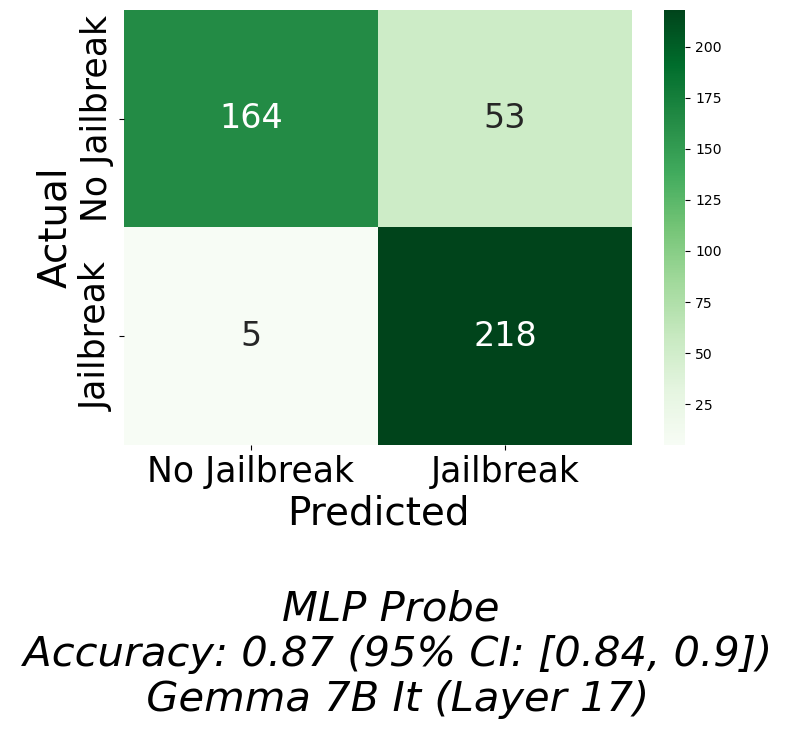

In [108]:
plot_confusion_matrix(conf_matrix = conf_matrix_mlp, accuracy = f"{mean_acc_mlp} (95% CI: [{conf_interval_mlp[0]}, {conf_interval_mlp[1]}])", probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=True)

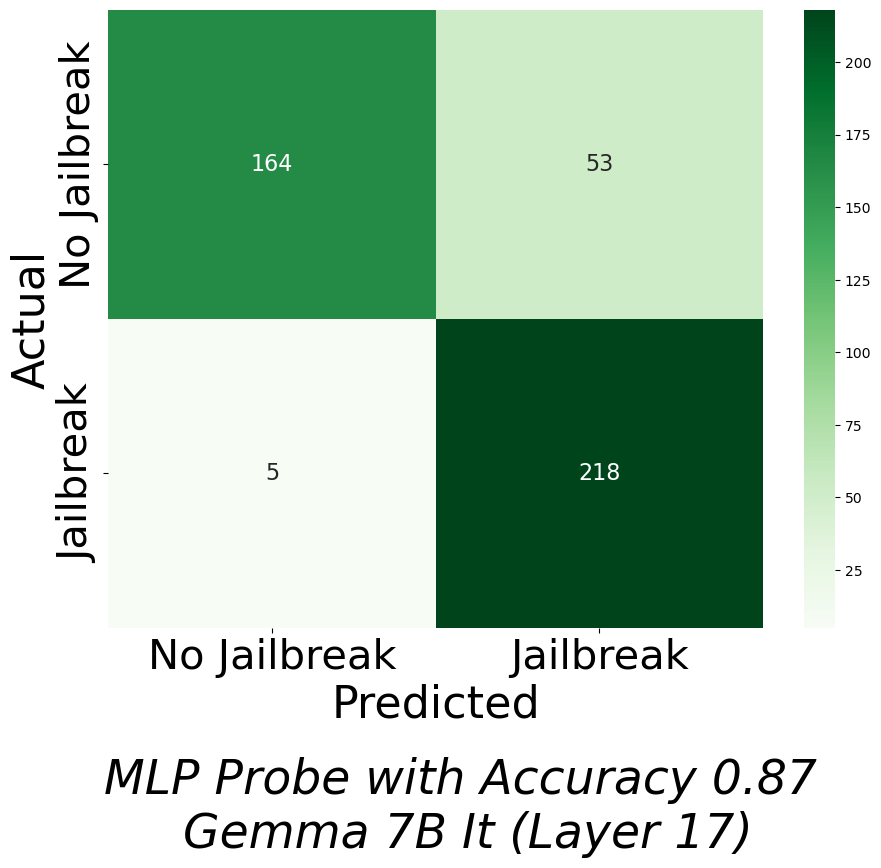

In [28]:
plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = round(scaler, 2), probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=False)

In [40]:
# Example usage:
mean_acc, conf_interval = bootstrap_confidence_interval(mlp, data[split_idx:], labels[split_idx:])
print(f'Mean Accuracy: {mean_acc}')
print(f'95% Confidence Interval: {conf_interval}')

Mean Accuracy: 0.87
95% Confidence Interval: (0.84, 0.9)


# using same Probes I used for the intervention 
- MLP ?? always predicts 0 ? 

In [29]:
from analysis.Probes import *
from analysis.supervised import *
import pickle

# import standard scaler


In [30]:
linear_probe_path = "/experiments/nathaly/linear_probe.pkl"
mlp_probe_path = "/experiments/nathaly/mlp_probe_weights.pth"

In [31]:
with open(linear_probe_path, 'rb') as f:
  saved_log_model = pickle.load(f)

In [32]:
log_acuracy = round(evaluate_logistic_regression_model(saved_log_model, data, labels, split_idx), 1)
log_acuracy

0.9

In [33]:
conf_matrix, log_acuracy = get_confusion_matrix(log_model = saved_log_model, X_test = data[split_idx:], y_test = labels[split_idx:])

conf_matrix, log_acuracy

array([[202,  22],
       [ 12, 204]])

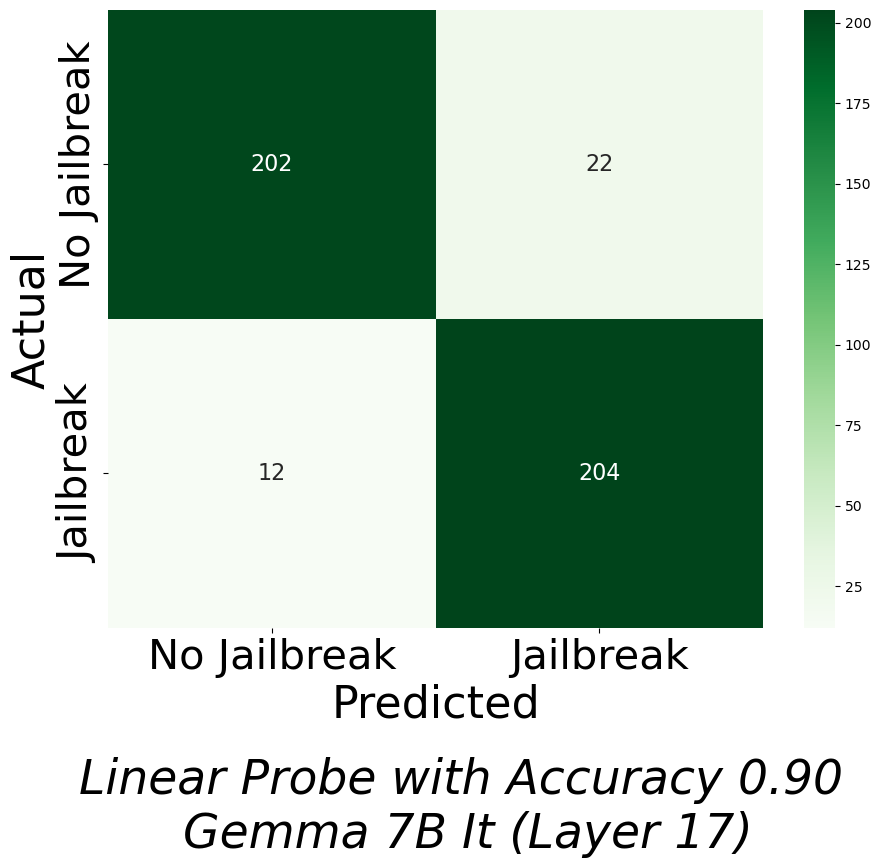

In [34]:
plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = log_acuracy, probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=False)

In [35]:
mlp = SimpleMLP()

# Load the model from the specified probe path
mlp.load_model(mlp_probe_path)

Model weights loaded from /data/nathalie_maria_kirch/ERA_Fellowship/experiments/nathaly/mlp_probe_weights.pth!


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(file_path))


In [36]:
evaluate_mlp_model(mlp_model = mlp, data = data, labels =labels , split_idx = split_idx) 


AttributeError: 'SimpleMLP' object has no attribute 'score'

In [45]:

scaler = StandardScaler()
scaler.fit(data[:split_idx])  

X_test = torch.tensor(scaler.transform(data[split_idx:]), dtype=torch.float32) # Replace with your test data
y_test = torch.tensor(labels[split_idx:],dtype=torch.float32)   # Replace with your test labels

# Set the model to evaluation mode
mlp.eval()

# Make predictions
with torch.no_grad():  # Disable gradient calculation
  y_pred = mlp(X_test)

  # Apply sigmoid to get probabilities
  y_probabilities = torch.sigmoid(y_pred)

  # Convert probabilities to binary labels (threshold at 0.5)
  y_pred_labels = (y_probabilities > 0.5).float()

  # Convert to numpy for compatibility with sklearn's accuracy_score
  y_test_np = y_test.numpy()
  y_pred_labels_np = y_pred_labels.numpy()

  # Calculate accuracy
  accuracy = round(accuracy_score(y_test_np, y_pred_labels_np),2)
  print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5300


In [38]:
from sklearn.metrics import confusion_matrix
import torch

def get_confusion_matrix(mlp_model, X_test, y_test):
    '''
    input: mlp_model (SimpleMLP), X_test (tensor or array), y_test (tensor or array)
    output: confusion matrix (array)
    '''

    # Convert test data to tensor if they are numpy arrays
    if isinstance(X_test, np.ndarray):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    if isinstance(y_test, np.ndarray):
        y_test = torch.tensor(y_test, dtype=torch.float32)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        # Get model predictions
        y_pred_logits = mlp_model(X_test)
        y_probabilities = torch.sigmoid(y_pred_logits)
        
        # Convert probabilities to binary labels (threshold at 0.5)
        y_pred_labels = (y_probabilities > 0.5).float()
        
    # Convert to numpy for compatibility with sklearn's confusion_matrix
    y_test_np = y_test.numpy()
    y_pred_labels_np = y_pred_labels.numpy()

    # Compute the confusion matrix
    return confusion_matrix(y_test_np, y_pred_labels_np)

In [39]:
mlp.eval()
conf_matrix = get_confusion_matrix(mlp, X_test, y_test)
print(conf_matrix)

[[209   7]
 [200  24]]


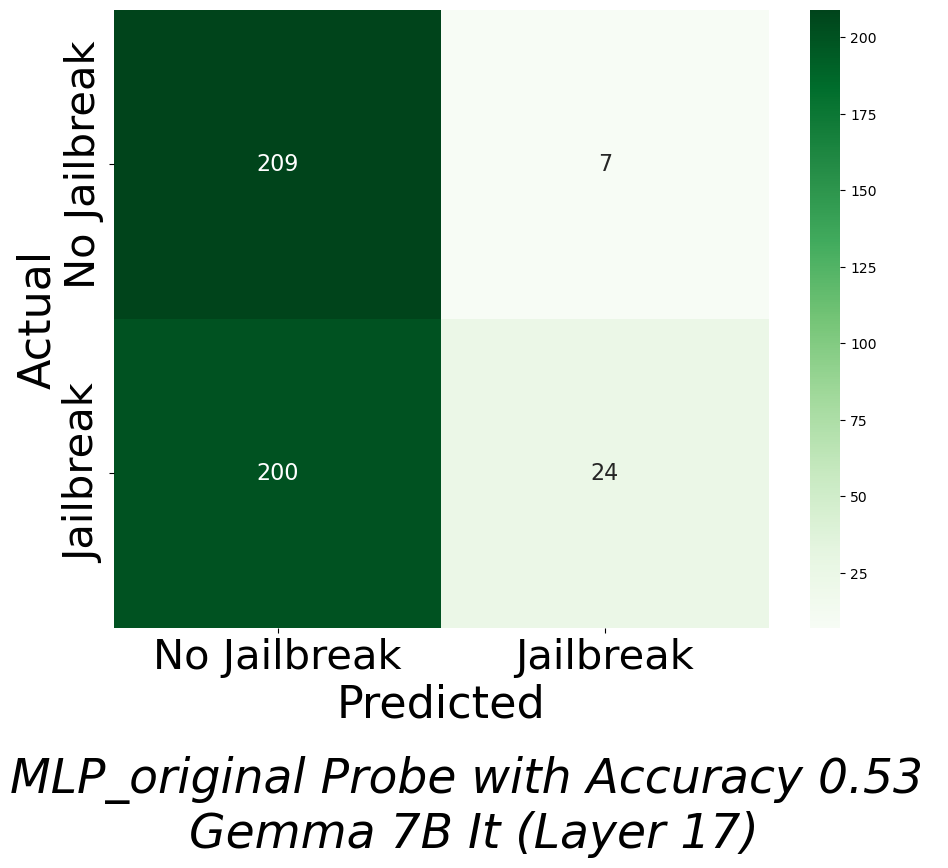

In [40]:
# get confusion matrix 
plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = accuracy, probe_type = "MLP_original", dataset_name= "", model_name = model_name, layer = layer, class_names= df["rating_binary"].unique(), save=False)